# Example notebook for supervised training of LTC cells using the Pytorch implementation

### Import requirements

In [5]:
import numpy as np                      # numpy  
import torch.nn as nn                   # pytorch neural network modules
import kerasncp as kncp                 # Keras LTC implementation (for Neural Circuit Policies)
from kerasncp.torch import LTCCell      # the LCP network module is actually part of the keras library
import torch                            # Pytorch
import pytorch_lightning as pl          # Pytorch Lightning for easy training
import torch.utils.data as data         # Data Utilities
import matplotlib.pyplot as plt         # Matplotlib for plotting

import LTCRL.utils as lru

print(kncp.__version__)                 # check the module version

2.0.0


### Implement a sequence unfolding module for RNN training
There is no such native implementation in pytorch, so as recommended by the authors of the LTC paper we implement our own (this is especially important as we use Backprop though time [BPTT] instead of the adjoint method, see LTC paper for a clarification of the distinction)

In [8]:
# nn.Module that unfolds a RNN cell into a sequence
# see implementation as:
lru.RNNSequence

LTCRL.utils.RNNSequence

In [24]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def optimizer_step(
        self,
        current_epoch,
        batch_nb,
        optimizer,
        optimizer_idx,
        closure,
        on_tpu=False,
        using_native_amp=False,
        using_lbfgs=False,
    ):
        optimizer.optimizer.step(closure=closure)
        # Apply weight constraints
        self.model.rnn_cell.apply_weight_constraints()

In [48]:
in_features = 2
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
print("data_x.size: ", str(data_x.size()))
print("data_y.size: ", str(data_y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

data_x.size:  torch.Size([1, 48, 2])
data_y.size:  torch.Size([1, 48, 1])


In [49]:
wiring = kncp.wirings.FullyConnected(8, out_features)  # 16 units, 8 motor neurons
ltc_cell = LTCCell(wiring, in_features)


ltc_sequence = RNNSequence(
    ltc_cell,
)
learn = SequenceLearner(ltc_sequence, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    gpus=0,
)

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


alloc!


In [50]:
results = trainer.test(learn, dataloader)

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 0.5080159902572632}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


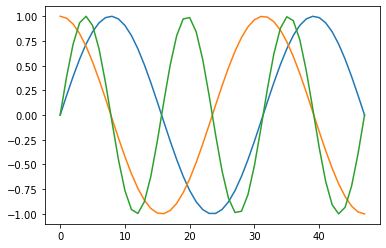

In [51]:
plt.plot(data_x[0,:,:])
plt.plot(data_y[0,:,:])